# Tree-Based Model Threshold Tuning & Final Decision
Goal: Given buisness priorities, what probability threshold should we use. We need to find the best probablity to limit risk (missed defaulters). 

By default, models predict:  

    default = 1 if probability ≥ 0.5

We have discovered:
* many true defaulters sit below 0.5
* the model ranks risk well since AUC improved
* business cost favors recall over precision

0.5 is the default but may not be the best probabity to use.  
Threshold tuning is aligning predictions with cost and risk.


In [15]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns

Load the data:

In [16]:
df = pd.read_csv("../data/credit_default.csv")

# Drop ID column
df.drop(columns=["ID"], inplace=True, errors="ignore")

df.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Define features (X) and target (y):

In [17]:
# Set target column
target_col = "default.payment.next.month"

# X is what we know, 
# y is what we want to predict
X = df.drop(columns=[target_col])
y = df[target_col]

X.shape, y.shape


((30000, 23), (30000,))

Train / Test split:

In [18]:
# Split arrays or matrices into random train and test subsets.

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


Let's verify similar distributions for a fair evaluation:

In [19]:
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

default.payment.next.month
0    0.778833
1    0.221167
Name: proportion, dtype: float64

# Build the Random Forest Model

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Define the pipeline:  
* n_estimators=200: 200 trees (100-300 is is a common baseline and more trees mean more stable predictions up to a point)
* random_state=42: controls randomness 
* n_jobs=-1: use all available CPU cores for faster training

Note: Tree models don’t require feature scaling, but helps keep preprocessing consistent across models for comparability

In [21]:
rf_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),  # optional but keeps things consistent
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

Train:

In [22]:
rf_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2


Let's do some quick verification checks:


In [23]:
# check that model trained successfully 
rf_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2


In [24]:
# parameters are reasonable
rf_pipeline.named_steps["model"]

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

Predictions & Evaluation  

Question:  
Did the Random Forest improve our ability to identify defaulters compared to logistic regression?

Make predictions:
* Hard predictions (0 or 1) (Does the model think the customer will default or not?)
* Probabilities (How likely is default?)

In [25]:
y_pred_rf = rf_pipeline.predict(X_test) # yes/no decisions
y_pred_rf_proba = rf_pipeline.predict_proba(X_test)[:, 1] # confidence in default risk

Let's generate predictions at multiple thresholds:
* Lower thesholds tend to provide more "yes" predictions
* Recall going up means fewer missed defaulters
* Precision  going down means more false alarms

**Idealy, we want to keep precision balenced and improve recall.**

In [26]:
probs = y_pred_rf_proba

In [27]:
thresholds = [0.3, 0.4, 0.5]

from sklearn.metrics import precision_score, recall_score

results = []

for t in thresholds:
    preds_t = (probs >= t).astype(int)
    results.append({
        "threshold": t,
        "precision": precision_score(y_test, preds_t),
        "recall": recall_score(y_test, preds_t)
    })

pd.DataFrame(results)


,threshold,precision,recall
0,0.3,0.494330,0.558402
1,0.4,0.576814,0.461191
2,0.5,0.630295,0.370008


Select a Threshold:

We will use 0.4  

    A threshold of 0.4 improves recall while keeping precision at an acceptable level.
    0.3 drops precsion below 0.5 and 0.5 has a better precsion but loses a meaningful amount of recall (defaulters) compared to 0.4.

Visualize results:  
Let's use a Confusion Matrix  
* This matrix shows how many predictions were correct and incorrect displaying specific errors 
    * false positives (predicted positive, actually negative)
    * false negatives (predicted negative, actually positive)

True Positives (TP)
* Actual default = 1
* Predicted default = 1
* We caught a defaulter  

False Negatives (FN)
* Actual default = 1
* Predicted no default = 0
* We missed a defaulter (costly)

False Positives (FP)
* Actual no default = 0
* Predicted default = 1
* False alarm

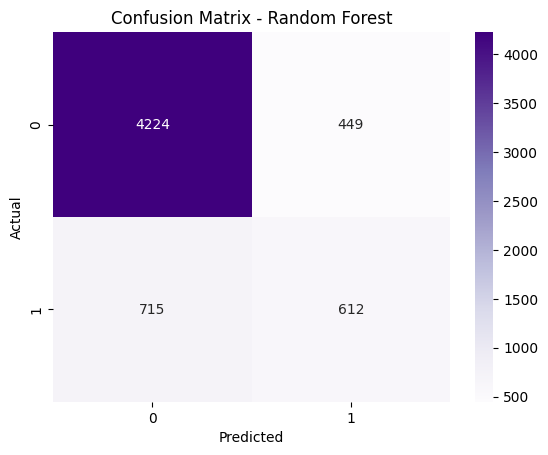

In [34]:
from sklearn.metrics import confusion_matrix

chosen_threshold = 0.4
final_preds = (probs >= chosen_threshold).astype(int)

cm_final = confusion_matrix(y_test, final_preds)

sns.heatmap(cm_final, annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

Compare this matrix (0.4) to 0.5 threshold:  
* Did true positives (TP) increase? **Yes**  
* Did false negatives (FN) decrease? **Yes**  
* Did false positives increase but stay within an acceptable boundary? **Yes**  

        Fewer FN = better at catching defaulters
        


Classification Report:
* Precision → Of everyone flagged as default, how many actually defaulted?
* Recall → Of all the real defaulters, how many did we catch?
* F1 → Balance of precision & recall
* Accuracy → NOT helpful for imbalanced data

What we are looking for:
* Did Recall for class 1 increase?
* Did precision for class 1 drop slightly?
* Did F1 for class 1 improve?

If yes to all, then we are moving in the correct direction

In [35]:
from sklearn.metrics import classification_report

print(classification_report(y_test, final_preds))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4673
           1       0.58      0.46      0.51      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.68      0.70      6000
weighted avg       0.79      0.81      0.80      6000



# Side-by-Side Comparison
| Metric              | Logistic Regression | Random Forest (0.5) | Random Forest (0.4) |
| ------------------- | ------------------- | ------------- | ------------- |
| Recall (default)    |       0.24              |     0.36          |     0.46          |
| Precision (default) |      0.69               |     0.63          |     0.58          |



Judgment:

The Random Forest model demonstrated improved recall over logistic regression, indicating better identification of defaulters. Because missed defaults carry a higher business cost than false alarms, the decision threshold was lowered from 0.5 to 0.4. This adjustment reduced false negatives and increased true positives while maintaining acceptable precision. As a result, the Random Forest with a 0.4 threshold was selected as the final model.